In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [2]:
conn = sqlite3.connect("ev.db")

In [3]:
pd.read_csv("webbsite_hk_private_cars_by_month.csv").to_sql('by_month', conn, if_exists='replace', index=False)
pd.read_csv("webbsite_hk_private_cars_monthly_SUM_2020_2025.csv").to_sql('monthly_sum', conn, if_exists='replace', index=False)

66

In [4]:
query = """
SELECT Brand, SUM(Total) AS units
FROM by_month
WHERE Year=2025 AND Month<=6
GROUP BY Brand
ORDER BY units DESC
LIMIT 15;
"""

In [5]:
top_brands = pd.read_sql_query(query, conn)

In [6]:
top_brands

,Brand,units
0,BYD,4909.0
1,TESLA,3889.0
2,TOYOTA,3403.0
3,HONDA,1173.0
4,B.M.W.,1024.0
5,ZEEKR,848.0
6,XPENG,770.0
7,M.G.,596.0
8,MERCEDES BENZ,489.0
9,DENZA,486.0


In [7]:
query_tesla_roll = """
WITH base AS (
  SELECT
    printf('%04d-%02d-01', Year, Month) AS ym,
    SUM(CASE WHEN UPPER(Brand)='TESLA' THEN Electric ELSE 0 END) AS tesla_ev,
    SUM(Electric) AS market_ev
  FROM by_month
  GROUP BY 1
),
roll AS (
  SELECT
    ym,
    SUM(tesla_ev)  OVER (ORDER BY ym ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS tesla_12m,
    SUM(market_ev) OVER (ORDER BY ym ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS market_12m
  FROM base
)
SELECT
  ym,
  tesla_12m,
  market_12m,
  CASE WHEN market_12m>0 THEN tesla_12m*1.0/market_12m END AS tesla_share_12m
FROM roll
ORDER BY ym;
"""

In [8]:
tesla_roll = pd.read_sql_query(query_tesla_roll, conn)
tesla_roll["ym"] = pd.to_datetime(tesla_roll["ym"])

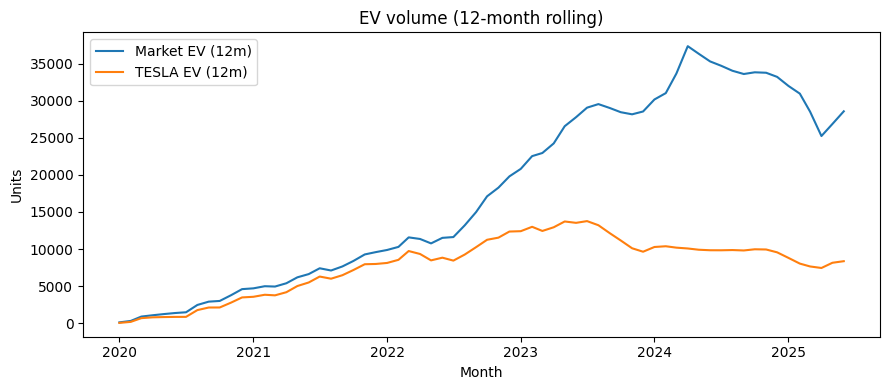

In [11]:
# EV volume rolling
plt.figure(figsize=(9,4))
plt.plot(tesla_roll["ym"], tesla_roll["market_12m"], label="Market EV (12m)")
plt.plot(tesla_roll["ym"], tesla_roll["tesla_12m"],  label="TESLA EV (12m)")
plt.title("EV volume (12-month rolling)")
plt.xlabel("Month")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.savefig("images_2/EV_volume_12month_rolling.png", dpi=300, bbox_inches="tight")
plt.show()

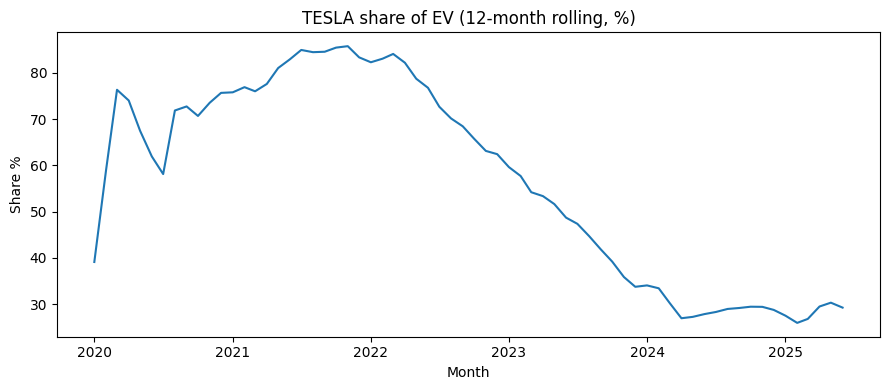

In [12]:
# Tesla share by 12 month rolling
plt.figure(figsize=(9,4))
plt.plot(tesla_roll["ym"], tesla_roll["tesla_share_12m"]*100)
plt.title("TESLA share of EV (12-month rolling, %)")
plt.xlabel("Month")
plt.ylabel("Share %")
plt.tight_layout()
plt.savefig("images_2/Tesla_share_of_EV_12_monthrolling.png", dpi=300, bbox_inches="tight")
plt.show()